# **Pairwise Sequence Alignment**

# The Needleman-Wunsch algorithm

The Needleman-Wunsch algorithm finds the optimal *global* alignment (end-to-end) between two sequences.
It consists of the following steps:

1. Construct the grid
2. Choose a scoring system (here we use the original scoring system assigning a score $s$ of 1 to a match, a score $s$ of -1 to a mismatch, and a score $d$ of -1 to a gap/indel)
3. Fill in the scoring matrix $F$ (and construct the pointer matrix on the way)
4. Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores in the scoring matrix $F$ are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\max
\begin{cases}
    F(i-1,j-1)+s(x_i,y_i),\\
    F(i-1,j)+d,\\
    F(i,j-1)+d.
\end{cases}
$$

The following image illustrates the scoring and pointer matrices.

<img src="nw-matrix.png" width="500" />

We can use the `make_align()` function from our `alignment` module to generate an `align()` function that performs the Needleman-Wunsch algorithm.

In [1]:
import alignment as aln

x = "GATTACA"
y = "CATACCCA"

align = aln.make_align(mode="global")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


We can also plot the alignment together with the scoring matrix:

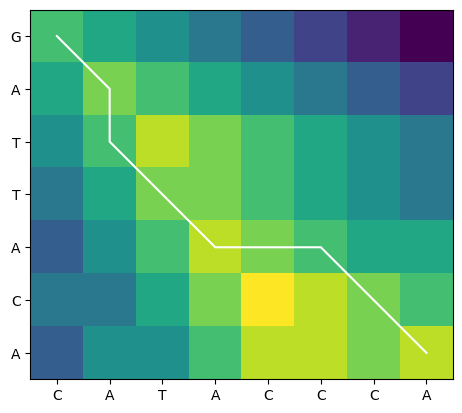

In [2]:
import matplotlib.pyplot as plt

plt.imshow(X=scoring_mat)
plt.plot(warp_path_y, warp_path_x, "w")
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.show()

# The Smith-Waterman algorithm

The Smith-Waterman algorithm finds the optimal *local* alignment between two sequences.
It is a variation of the Needleman-Wunsch algorithm.

The three main differences are:

|                | Smith-Waterman algorithm                                | Needleman-Wunsch algorithm                                                 |
|----------------|---------------------------------------------------------|----------------------------------------------------------------------------|
| Initialization | First row/column = 0                                    | First row/column subject to gap penalty                                    |
| Scoring        | Negative scores are set to 0                            | Scores can be negative                                                     |
| Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

Again, with our `alignment` module, we can perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`.

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [ 5 16]


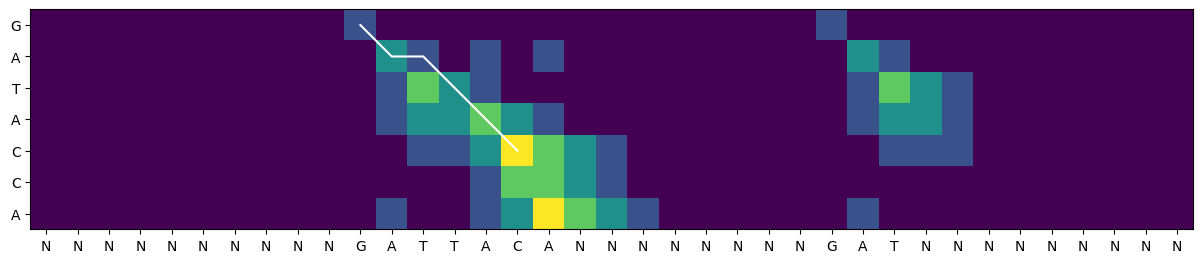

In [3]:
x = "GATACCA"
y = "NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN"

align = aln.make_align(mode="local")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

plt.figure(figsize=[15, 8])
plt.imshow(X=scoring_mat)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(warp_path_y, warp_path_x, "w")
plt.show()

# Read alignment

We can also simulate the alignment of many reads originating from e.g., a bulk DNA sequencing experiment.

First, we simulate the generation of a number of reads, by sampling  5 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [19]:
import random

reference_sequence = "GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA"

n_reads = 5
min_read_len = 15
max_read_len = 20

reads = []

while len(reads) < n_reads:
    range_acquired = False
    while not range_acquired:
        start_position = random.randrange(len(reference_sequence))
        end_position = random.randrange(len(reference_sequence))
        if start_position > end_position:
            continue
        range_len = end_position - start_position + 1
        if range_len < min_read_len or range_len > max_read_len:
            continue
        range_acquired = True
    read = reference_sequence[start_position : (end_position + 1)]
    reads.append(read)

print(reads)

['GTATCGATCAAATAGTA', 'GTATCGATCAAATAG', 'GCAGTATCGATCAAATA', 'AAATCCATTTGTTCAACTC', 'TCCATTTGTTCAACT']


Next we add some noise to the sampled reads.

In [22]:
def add_noise(read: str, noiselessness: int = 4) -> (str, int):
    choices = ["A", "C", "G", "T"]
    n_noisy_bases = 0
    noisy_read = ""
    for base in read:
        if not random.randrange(noiselessness):
            noisy_read += random.choice(seq=[c for c in choices if c != base])
            n_noisy_bases += 1
        else:
            noisy_read += base
    return noisy_read, n_noisy_bases


noisy_reads = []
for read in reads:
    noisy_read, n_noisy_bases = add_noise(read=read, noiselessness=3)
    print(f"Added {n_noisy_bases} noisy base(s): {read:10s} -> {noisy_read:10s}")
    noisy_reads.append(noisy_read)

Added 4 noisy base(s): GTATCGATCAAATAGTA -> GTATCGGACAAATAATG
Added 7 noisy base(s): GTATCGATCAAATAG -> ACAACGTTCACAGGG
Added 7 noisy base(s): GCAGTATCGATCAAATA -> GCCGGACTACTCAAACA
Added 9 noisy base(s): AAATCCATTTGTTCAACTC -> AGTTCCCAGTGTACATCAA
Added 8 noisy base(s): TCCATTTGTTCAACT -> ACGACCACTTTAACC


We now align the noisy reads locally to the reference sequence.
We also compute the residual of each noisy read w.r.t. the reference sequence.

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [14 32]
Read                   : GTATCGGACAAATAATG
Aligned read           : GTATCGGA-CAAATA
Aligned read w/o gaps  : GTATCGGACAAATA
Number of clipped bases: 3
Reference subsequence  : GTATCGATCAAATA


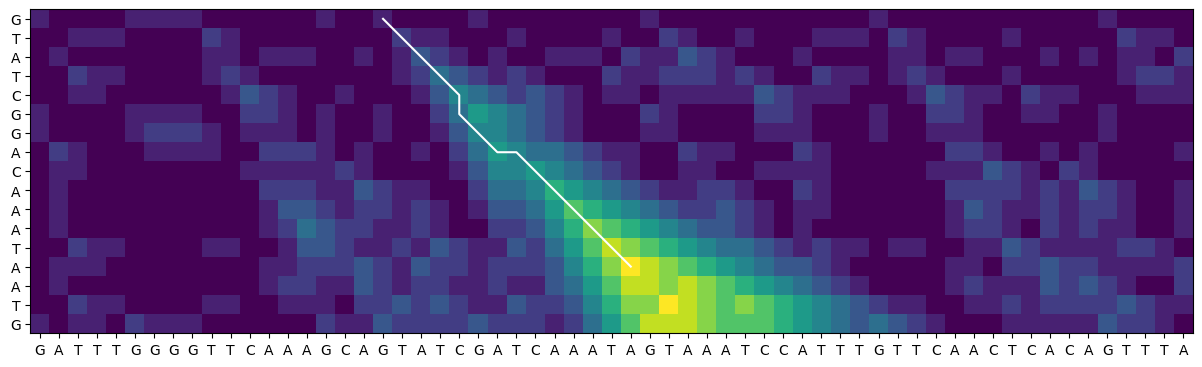

Read                   : ACAACGTTCACAGGG
Aligned read           : CAACGTTCACAG
Aligned read w/o gaps  : CAACGTTCACAG
Number of clipped bases: 3
Reference subsequence  : CAACTCACAG


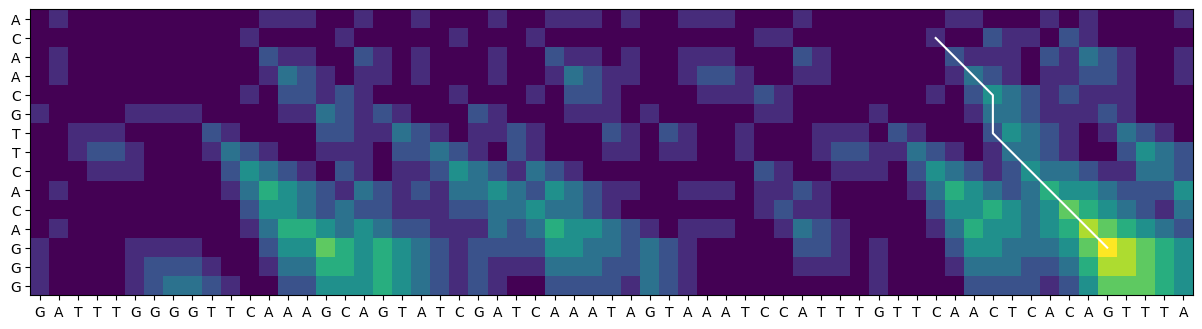

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [17 32]
Read                   : GCCGGACTACTCAAACA
Aligned read           : GCCGGA-CTACTCAAACA
Aligned read w/o gaps  : GCCGGACTACTCAAACA
Number of clipped bases: 0
Reference subsequence  : GCAGTATCGATCAAATA


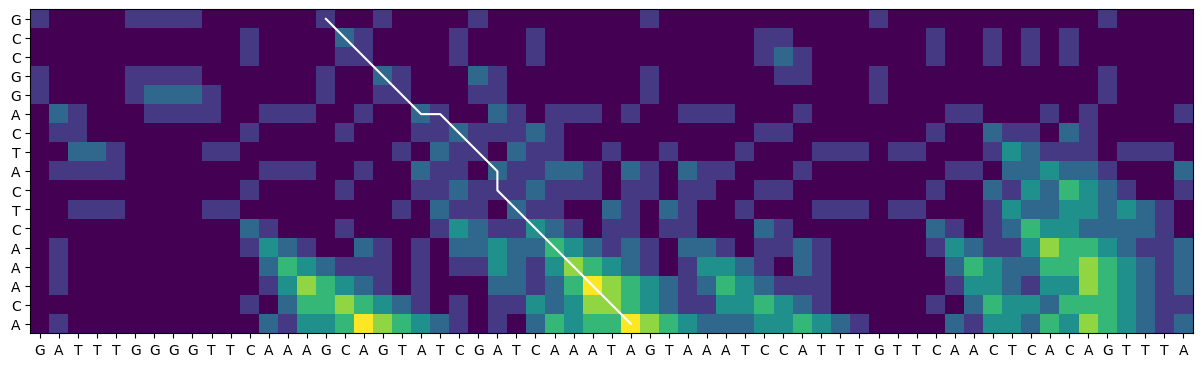

Read                   : AGTTCCCAGTGTACATCAA
Aligned read           : GTTCCCAG-TGTA-C-ATCAA
Aligned read w/o gaps  : GTTCCCAGTGTACATCAA
Number of clipped bases: 1
Reference subsequence  : GTTCAAAGCAGTATCGATCAA


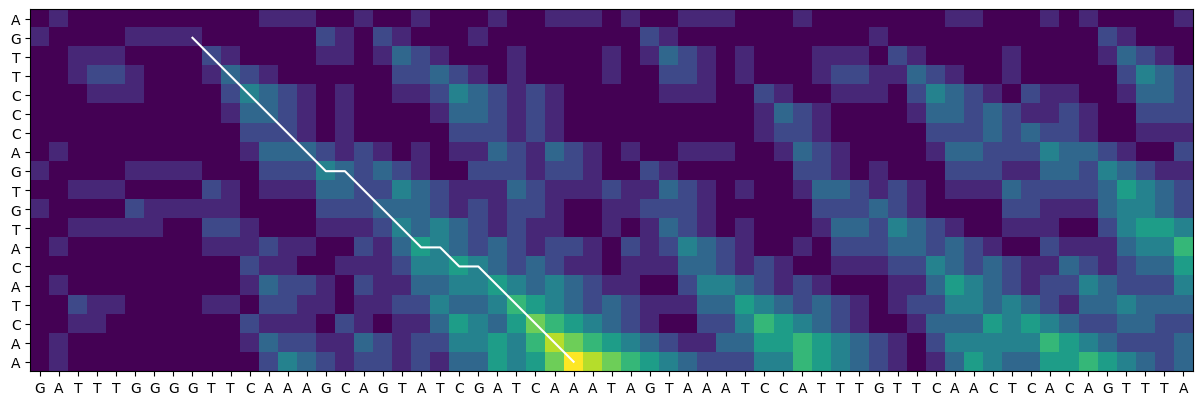

Read                   : ACGACCACTTTAACC
Aligned read           : AC-CAC--TTTA
Aligned read w/o gaps  : ACCACTTTA
Number of clipped bases: 6
Reference subsequence  : ACTCACAGTTTA


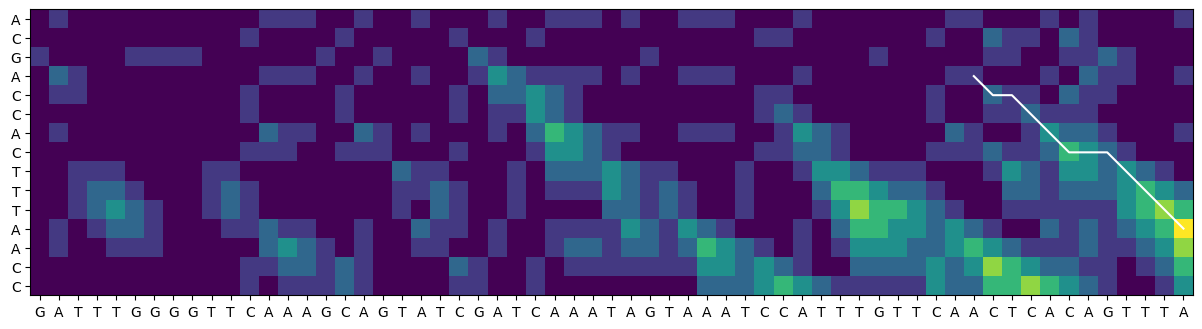

In [23]:
residuals = []

for read in noisy_reads:
    align = aln.make_align(mode="local")
    read_aln, ref_aln, warp_path_read, warp_path_ref, scoring_mat = align(
        seq_a=read, seq_b=reference_sequence
    )

    print(f"Read                   : {read}")
    print(f"Aligned read           : {''.join(read_aln)}")
    aligned_read_without_gaps = list(filter(lambda elem: elem != "-", read_aln))
    print(f"Aligned read w/o gaps  : {''.join(aligned_read_without_gaps)}")
    print(f"Number of clipped bases: {len(read) - len(aligned_read_without_gaps)}")
    print(
        f"Reference subsequence  : {reference_sequence[warp_path_ref[0] : (warp_path_ref[-1] + 1)]}"
    )

    plt.figure(figsize=[15, 8])
    plt.imshow(X=scoring_mat)
    plt.plot(warp_path_ref, warp_path_read, "w")
    plt.xticks(ticks=range(len(reference_sequence)), labels=reference_sequence)
    plt.yticks(ticks=range(len(read)), labels=read)
    plt.show()